For first exercises block see the notebook

## Second block

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Load the monthly dataset
data_monthly = pd.read_csv(os.path.join("..", "data", "monthly_in_situ_co2_mlo.csv"), header=56)
 
# - replace -99.99 with NaN
data_monthly.replace(to_replace=-99.99, value=np.nan, inplace=True)

# fix column names
cols = ["year", "month", "--", "--", "CO2", "seasonaly_adjusted", "fit",
        "seasonally_adjusted_fit", "CO2_filled", "seasonally_adjusted_filled"]
data_monthly.columns = cols
cols.remove("--"); cols.remove("--")
data_monthly = data_monthly[cols]

# drop rows with nan
data_monthly.dropna(inplace=True)

# fix time index
data_monthly["day"] = 15
data_monthly.index = pd.to_datetime(data_monthly[["year", "month", "day"]])
cols.remove("year")
cols.remove("month")
data_monthly = data_monthly[cols]

# function to convert datetimes to numbers that are useful to algorithms
#   this will be useful later when doing prediction

def dates_to_idx(timelist):
    reference_time = pd.to_datetime('1958-03-15')
    t = (timelist - reference_time) / pd.Timedelta(1, "Y")
    return np.asarray(t)

t = dates_to_idx(data_monthly.index)

# normalize CO2 levels
y = data_monthly["CO2"].values
first_co2 = y[0]
std_co2 = np.std(y)
y_n = (y - first_co2) / std_co2

data_monthly = data_monthly.assign(t = t)
data_monthly = data_monthly.assign(y_n = y_n)

### Es 1
Try to explain why all of our predictions underestimate the CO2 emission rate in the prediction set.

### Es 2
Divide the CO2 data we fitted above into a train and test set without regard for the temporal ordering (you can use KFold cross validation too).

In [2]:
from sklearn.model_selection import train_test_split
from numpy import atleast_2d, concatenate

X = data_monthly.t.values[:, None]
y = data_monthly.y_n.values

target = data_monthly.y_n.values
X_train, X_test,y_train, y_test = train_test_split(data_monthly.t.values, target,\
                                                   test_size = 0.2, random_state=0)
X_train = atleast_2d(X_train).T
X_test = atleast_2d(X_test).T

In [3]:
def plot_predictions(gp, include_observed=True):
    pred_y, pred_std = gp.predict(X, return_std=True)
    plt.figure(figsize=(10, 7))
    x = X[:, 0]
    if include_observed:
        plt.plot(x, y, 'ok', alpha=0.1)
    l, = plt.plot(x, pred_y)
    plt.fill_between(x,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)

### Es 3
Fit a GP using increasingly complex kernels (start from a single RBF and move onto the full kernel used above).

In [4]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

k1 = 50**2 * RBF(length_scale=50.0) # Long term trend

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=k1, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp0

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50), n_restarts_optimizer=3,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [5]:
gp0.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50), n_restarts_optimizer=3,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

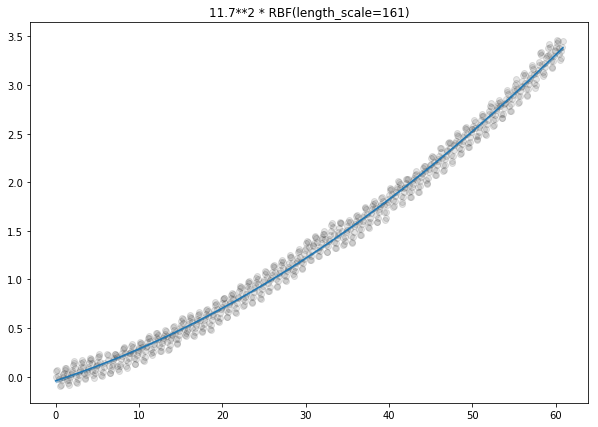

In [6]:
plot_predictions(gp0)
plt.title(str(gp0.kernel_));

0.0861**2 * RBF(length_scale=0.201) + 7.06**2 * RBF(length_scale=123) + WhiteKernel(noise_level=0.001)

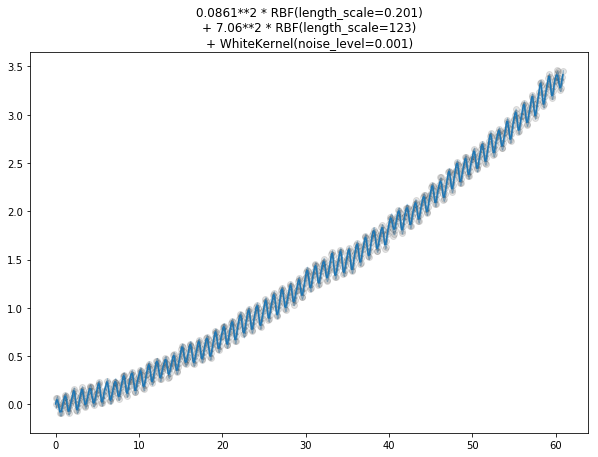

In [7]:
k1 = 50**2 * RBF(length_scale=50.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k4
gp1 = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp1.fit(X_train, y_train)
plot_predictions(gp1)
plt.title(str(gp1.kernel_).replace(' +', '\n+'))
gp1.kernel_

12.1**2 * RBF(length_scale=163) + 0.211**2 * RBF(length_scale=1e+05) * ExpSineSquared(length_scale=2.42, periodicity=1)

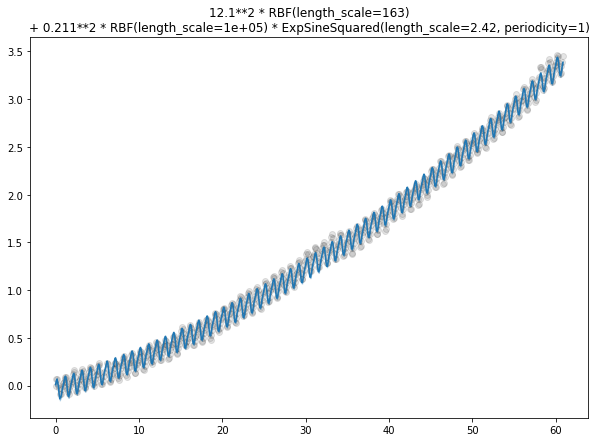

In [8]:
k1 = 50**2 * RBF(length_scale=50.0) # Long term trend
k2 = 20 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=12.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
kernel = k1 + k2
gp2 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp2.fit(X_train, y_train)
plot_predictions(gp2)
plt.title(str(gp2.kernel_).replace(' +', '\n+'))
gp2.kernel_

7.89**2 * RBF(length_scale=128) + 0.2**2 * RBF(length_scale=254) * ExpSineSquared(length_scale=2.31, periodicity=1) + 0.0258**2 * RBF(length_scale=2.73) + WhiteKernel(noise_level=0.001)

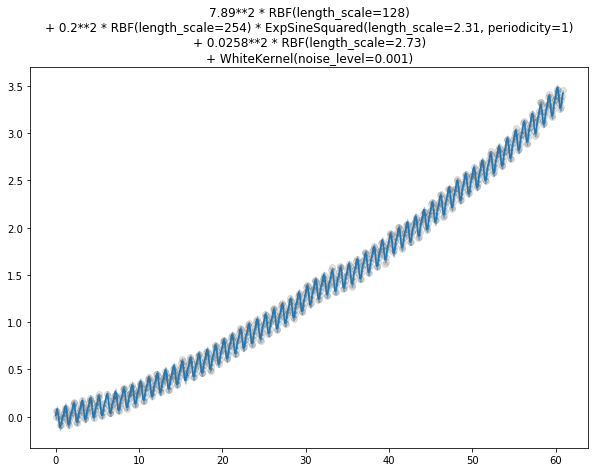

In [9]:
k1 = 50**2 * RBF(length_scale=50.0)
k2 = 20 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k2 + k4
gp3 = GaussianProcessRegressor(kernel=kernel, alpha=0.0,
                               normalize_y=True,
                               n_restarts_optimizer=3)
gp3.fit(X_train, y_train)
plot_predictions(gp3)
plt.title(str(gp3.kernel_).replace(' +', '\n+'))
gp3.kernel_

7.89**2 * RBF(length_scale=128) + 0.2**2 * RBF(length_scale=254) * ExpSineSquared(length_scale=2.31, periodicity=1) + 0.0881**2 * RationalQuadratic(alpha=3.29, length_scale=129) + 0.0258**2 * RBF(length_scale=2.73) + WhiteKernel(noise_level=0.001)

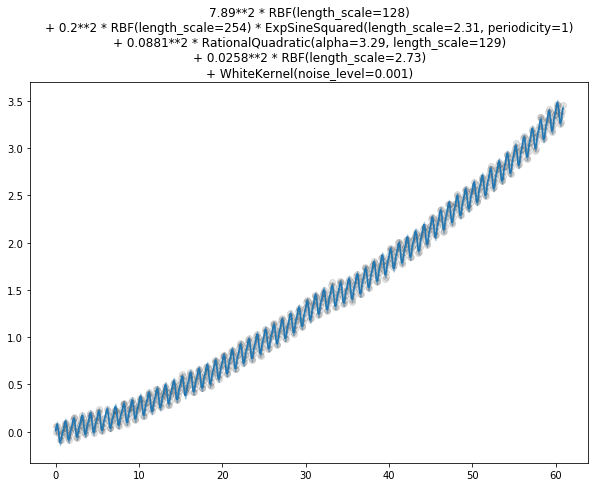

In [10]:
k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-3, 1e9))  # noise terms
kernel = k1 + k2 + k3 + k4

gp_full = GaussianProcessRegressor(kernel=kernel, alpha=0,
                                   normalize_y=True,
                                   n_restarts_optimizer=3)
gp_full.fit(X_train, y_train)
plot_predictions(gp_full)
plt.title(str(gp_full.kernel_).replace(' +', '\n+'))
gp_full.kernel_

### Es 4
Score each model and see which one gets the best score on the test set.

In [11]:
g_ps = [gp0, gp1, gp2, gp3, gp_full]

for g_p in g_ps:
    print("KERNEL", str(g_p), "HAS SCORED:", g_p.score(X, y) )

KERNEL GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50), n_restarts_optimizer=3,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None) HAS SCORED: 0.9935149903737337
KERNEL GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
             n_restarts_optimizer=3, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None) HAS SCORED: 0.9997983251293042
KERNEL GaussianProcessRegressor(alpha=0.01, copy_X_train=True,
             kernel=50**2 * RBF(length_scale=50) + 4.47**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=12, periodicity=1),
             n_restarts_optimizer=3, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None) HAS SCORED: 0.9992646851386183
KERNEL GaussianProcessRegressor(alpha=0.0, copy_X_train=True,
             kern

### Es 5
Visualize the learnt kernels with the 'auto-covariance' (what we called similarity at the begining of the notebook)

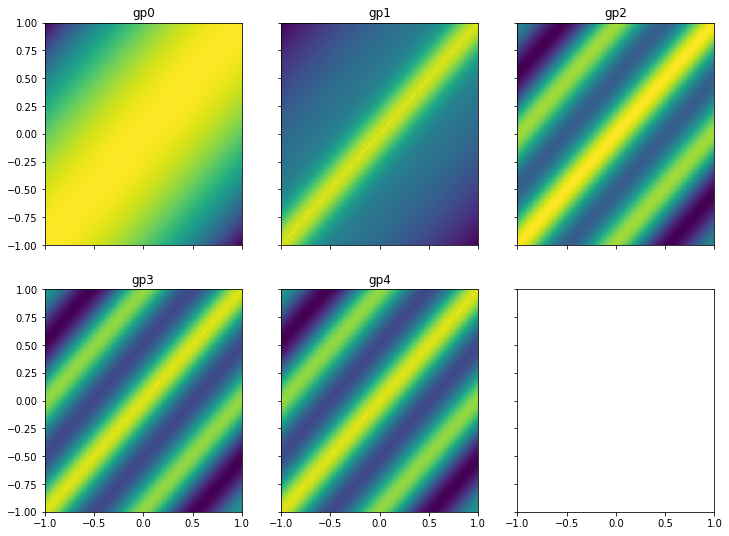

In [12]:
x = np.linspace(-1, 1, 363)
fig, axs = plt.subplots(2, 3, figsize=(12, 9), sharex=True, sharey=True)
for i, g_p in enumerate(g_ps):
    ax = axs[i // 3, i % 3]
    vals = g_p.kernel_(x[:, None])
    ax.pcolor(x, x, vals.reshape((len(x), len(x))))
    ax.set_title("gp"+str(i))


### Es 6
Draw samples from the GPs for the time range in between 2003 and 2018 and plot them, along with the mean and standard deviation of the GP prediction.

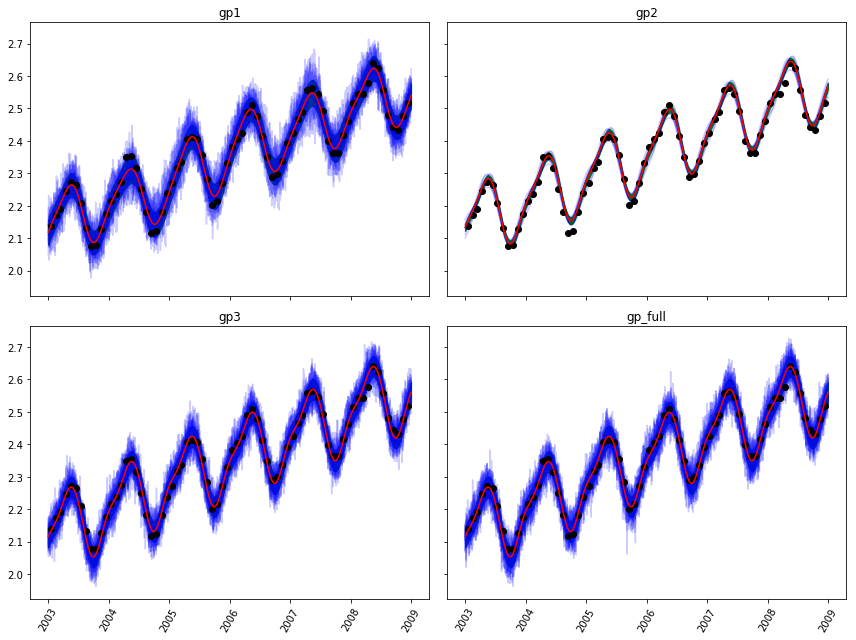

In [31]:
start = pd.to_datetime('2003-1-1')
end = pd.to_datetime('2008-12-31')
sample_range = pd.date_range(start=start,
                             end=end,
                             freq='D')
sample_x = dates_to_idx(sample_range)
data_in_range = data_monthly[start:end]
x_in_range = data_in_range.t.values
y_in_range = data_in_range.y_n.values

gps = [gp1, gp2, gp3, gp_full]
titles = ['gp1', 'gp2', 'gp3', 'gp_full']
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 9))
for i, (gp, title) in enumerate(zip(gps, titles)):
    ax = axs[i // 2, i % 2]
    sample_y = gp.sample_y(sample_x[:, None], n_samples=10)
    pred_y, pred_std = gp.predict(sample_x[:, None], return_std=True)
    ax.plot(sample_range, sample_y, 'b', alpha=0.2)
    ax.plot(data_in_range.index.get_values(), y_in_range, 'ok')
    ax.plot(sample_range, pred_y, color = "red")
    ax.fill_between(sample_range,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color="green")
    ax.set_title(title)
    if i // 2 == 1:
        ax.tick_params(axis='x', labelrotation=60)
fig.tight_layout()

## Block 3

1. Fit the iris dataset (only use the first 2 features) with GPCs that use different kernels (try Matern, RBF and DotProduct), both isotropic and anisotropic.
2. Do a cross validation to find the best performing GPC-kernel model.

In [32]:
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn import model_selection
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = np.array(iris.target, dtype=int)

In [33]:
kernels = [RBF(length_scale=1),
           RBF(length_scale=np.ones(X.shape[1])),
           Matern(length_scale=1),
           Matern(length_scale=np.ones(X.shape[1])),
           DotProduct()]

gps = []
all_scores = []
for kernel in kernels:
    gp = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=5)
    kf = model_selection.KFold(n_splits=5, shuffle=True)
    score = 'precision_macro'
    scores = model_selection.cross_val_score(
        gp,
        X,
        y,
        cv=kf,
        scoring=score,
        n_jobs=-1
    )
    gps.append(gp)
    all_scores.append(scores)
all_scores = np.array(all_scores)
print(all_scores)
best_gp = gps[np.argmax(np.mean(all_scores, axis=1))]
print(best_gp)

[[0.84259259 0.83333333 0.92307692 0.77380952 0.73611111]
 [0.80681818 0.82222222 0.82936508 0.79365079 0.79807692]
 [0.82407407 0.83333333 0.72916667 0.91666667 0.75163399]
 [0.9        0.8956229  0.6980057  0.86111111 0.75925926]
 [0.83939394 0.81818182 0.77777778 0.71481481 0.85353535]]
GaussianProcessClassifier(copy_X_train=True,
             kernel=Matern(length_scale=[1, 1], nu=1.5),
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=5, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)


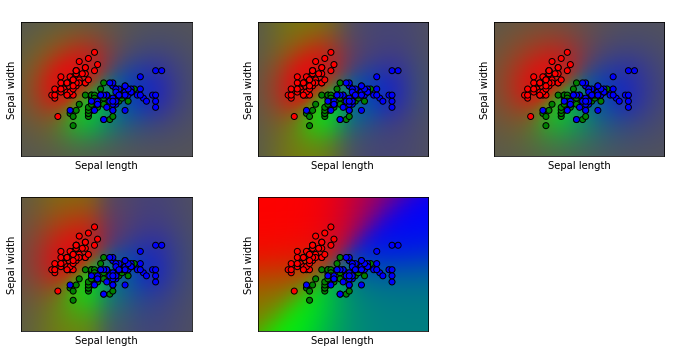

In [50]:
# create a mesh to plot in
h = .02  # step size in the mesh


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


plt.figure(figsize=(10, 5))
for i, clf in enumerate(gps):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    plt.subplot(2, 3, i + 1)
    clf.fit(X,y)
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape((xx.shape[0], xx.shape[1], 3))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y],
                edgecolors=(0, 0, 0))
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(" ")

plt.tight_layout()
plt.plot(figsize = (12,9))
plt.show()